# Tutorial - Reservoir Storage and Change

## Content
* [Setup](#Setup)
* [1. load location of reservoirs](#load-location-of-reservoirs)
* [2. load Landsat-8 imagery](#load-landsat-8-imagery)
* [3. calculate NDWI](#calculate-ndwi)
* [4. create monthly mosaic and calculate water area](#create-monthly-mosaic)
* [5. calculate storage](#calculate-storage)

## Setup <a class="anchor" id="Setup"></a>

Install the required packages using the following command - 
`conda install -c conda-forge earthengine-api geemap numpy pandas matplotlib geopandas jupyterlab`.

You may already have these packages installed from your previous tutorials. If so, activate that environment using `conda activate <env_name>`. Else, you can install the packages using the command in the line above.

In [1]:
import ee
import numpy as np
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


## load location of reservoirs <a class="anchor" id="load-location-of-reservoirs"></a>

We will now load the locations of the four reservoirs. 

The locations of four dams - Mica, Revelstoke, Mansfield and Tom Miller - are present in `assets/reservoirs.geojson` and `assets/dams.geojson` files. The `reservoirs` file contains the boundary of the reservoir as a polygon and the `dams` file contains the location of dam as a point.

Let's load them and inspect the contents of the files.

In [34]:
# location of two files, dams.geojson and reservoirs.geojson to read from
dams_path = 'assets/dams.geojson'
reservoirs_path = 'assets/reservoirs.geojson'

dams_gpd = gpd.read_file(dams_path)
reservoirs_gpd = gpd.read_file(reservoirs_path)

# how many dams are present in the dataset? What is their names?
print(f"Number of entries in files:\n  Dams:{len(dams_gpd)}\n  Reservoirs: {len(reservoirs_gpd)}")
print(f"Dam names: ", dams_gpd['DAM_NAME'].tolist())

Number of entries in files:
  Dams:4
  Reservoirs: 4
Dam names:  ['Mica', 'Revelstoke', 'Mansfield Dam', 'Tom Miller Dam']


In [35]:
# select a dam of choice
DAM = "Revelstoke"
print(f"Selected Dam: {DAM}")

# extract the row where the value of DAM_NAME column equals the DAM variable
selected_dam = dams_gpd[dams_gpd['DAM_NAME'] == DAM]
selected_reservoir = reservoirs_gpd[reservoirs_gpd['DAM_NAME'] == DAM]

selected_dam

Selected Dam: Revelstoke


,GRAND_ID,RES_NAME,DAM_NAME,ALT_NAME,RIVER,ALT_RIVER,MAIN_BASIN,SUB_BASIN,NEAR_CITY,ALT_CITY,...,MULTI_DAMS,TIMELINE,COMMENTS,URL,QUALITY,EDITOR,LONG_DD,LAT_DD,POLY_SRC,geometry
1,257,Revelstoke,Revelstoke,None,Columbia,None,None,None,Revelstoke,None,...,None,None,None,None,2: Good,McGill-BL,-118.193246,51.052067,Other,POINT (-118.19325 51.05207)


Convert the polygon and point features to earth engine `Feature` objects so that we can use them within Earth Engine.

In [36]:
selected_reservoir_gee = ee.Feature(geemap.geopandas_to_ee(selected_reservoir).first())
selected_dam_gee = ee.Feature(geemap.geopandas_to_ee(selected_dam).first())

Map = geemap.Map()

Map.addLayer(selected_reservoir_gee, {}, f"Reservoir: {DAM}")
Map.addLayer(selected_dam_gee, {}, f"Dam: {DAM}")
Map.centerObject(selected_dam_gee, zoom=9)

Map

Map(center=[51.05206700000001, -118.19324600000004], controls=(WidgetControl(options=['position', 'transparent…

Now we have the reservoir and dam locaation. We can use these features to filter and reduce the landsat-8 imagecollection to variables that we require (water area). 

## load landsat-8 imagery <a class="anchor" id="load-landsat-8-imagery"></a>

We will now load the landsat imagecollection. Remember we have to filter it by the region of our interest, which is the location of the reservoir. We also need to filter it with a range of dates that we are interested in finding the storage for.

In [37]:
startDate = ee.Date("2022-10-01")
endDate = ee.Date("2024-09-30")

landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")

# use the shapefiles and dates to filter out the landsat images
landsat8Filtered = landsat8.filterBounds(selected_reservoir_gee.geometry()).filterDate(
    startDate, endDate
).filter(
    ee.Filter.lte("CLOUD_COVER", 90)
)

# function to preprocess Landsat 8 images
def preprocessLandsat8(image):
    # mask for unwanted pixels (fill, dilated cloud, cirrus, cloud, cloud shadow, snow)
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qa_mask = image.select("QA_PIXEL").bitwiseAnd(int("111111", 2)).eq(0)
    # mask for saturated pixels
    saturation_mask = image.select("QA_RADSAT").eq(0)

    # Apply scaling factors to the surface reflectance and thermal bands
    opticalBands = image.select("SR_B.").multiply(0.0000275).add(-0.2)
    thermalBands = image.select("ST_B.*").multiply(0.00341802).add(149.0)

    # Add bands to the image and mask unwanted pixels
    return (
        image.addBands(opticalBands, overwrite=True)
        .addBands(thermalBands, overwrite=True)
        .updateMask(qa_mask)
        .updateMask(saturation_mask)
    )

## calculate NDWI <a class="anchor" id="calculate-ndwi"></a>

To calculate storage, we first need to calculate the water area of the reservoir. Using the water area and the between Area-Volume, we can calculate the storage. Let's first calculate the water surface area of the reservoir.

Recall from previous tutorials that we used a ratio of two bands to identify which pixels are water. Water appears bright (reflects) in the Green band and dull (absorbs) in the Near InfraRed frequency. By taking the ratio of the difference of Green and NIR and the sum of the two, water pixels get a high positive value. Pixels higher than 0.1-0.3 NDWI are considered water. 

The NDWI is given as the normalized difference between the reflectances in the Green and NIR bands.

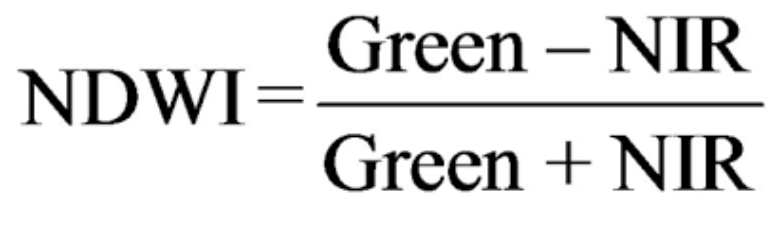

In Landsat-8 imagery, the Green band is named `SR_B3` and NIR band is `SR_B5`.

Question: Write a function for calculating NDWI. Hint: you can use an expression.

In [38]:
# function to calculate and add NDWI band
def addNDWI(image):
    ndwi = image.expression(
        "NDWI = (green - NIR)/(green + NIR)",
        {
            "green": image.select("SR_B3"),
            "NIR": image.select("SR_B5")
        },
    ).rename("NDWI")

    return image.addBands(ndwi)

Let's inspect if the functions we defined are working as expected.

Tasks:
1. get the first image in the filtered landsat imagecollection `landsat8Filtered`.
2. preprocess the image: remove clouds (hint: there is a function to do that above) and apply scaling.
3. calculate ndwi using the `addNDWI` function.
4. run the cell below to plot the images and see if you get results as expected. The Raw layer should be a regular image. Preprocessed layer should have the clouds removed. The NDWI layer should show water as blue.

In [39]:
im = landsat8Filtered.first()
preprocessed_im = preprocessLandsat8(im)
ndwi = addNDWI(preprocessed_im)

Map = geemap.Map()

Map.addLayer(selected_reservoir_gee, {}, f"Reservoir: {DAM}")
Map.addLayer(selected_dam_gee, {}, f"Dam: {DAM}")
Map.addLayer(
    im,
    {"bands": ["SR_B4", "SR_B3", "SR_B2"]},
    "Landsat 8 - Raw"
)
Map.addLayer(
    preprocessed_im,
    {"bands": ["SR_B4", "SR_B3", "SR_B2"]},
    "Landsat 8 - Preprocessed"
)
Map.addLayer(
    ndwi,
    {"bands": ["NDWI"], 'palette': ['FFFFFF', '0000FF']},
    "Landsat 8 - NDWI"
)
Map.centerObject(selected_dam_gee, zoom=9)

Map

Map(center=[51.05206700000001, -118.19324600000004], controls=(WidgetControl(options=['position', 'transparent…

## create monthly mosaic and calculate water area <a class="anchor" id="create-monthly-mosaic"></a>

Now that we have the functions required to get the NDWI for a single image, we will use them to calculate the water area time-series. However, we first have to create a mosaic. By creating a mosaic we will make sure that an observation of the entire reservoir is made. Further, by combining all images within a month we can address the presence of clouds that may obstruct the view. If clouds obstruct the view during one overpass, during another overpass in that month there may clouds may not be present. If it is still cloudy, we are out of luck!

Let's create a mosaic for July of 2023.

In [40]:
# Specify mosaic date range
mosaicStartDate = ee.Date("2023-10-01")
mosaicEndDate = ee.Date("2023-10-31")

# Create a mosaic of the Landsat 8 images and apply the preprocessing step and add NDWI bands
mosaic = (
    landsat8.filterBounds(selected_reservoir_gee.geometry())
    .filterDate(mosaicStartDate, mosaicEndDate)
    .map(preprocessLandsat8)
    .map(addNDWI)
    .mosaic()
)


# Map
Map = geemap.Map()

Map.addLayer(
    mosaic,
    {"bands": ["NDWI"], 'palette': ['FFFFFF', '0000FF']},
    "Landsat 8 Mosaic - NDWI"
)
Map.addLayer(selected_reservoir_gee, {'opacity':0.1}, f"Reservoir: {DAM}")
Map.addLayer(selected_dam_gee, {}, f"Dam: {DAM}")
Map.centerObject(selected_dam_gee, zoom=9)

Map

Map(center=[51.05206700000001, -118.19324600000004], controls=(WidgetControl(options=['position', 'transparent…

The mosaic combines many landsat images together. You can see the entire extent of the reservoir here.

Now we will create monthly mosaics for the water years 2023 to 2024. We need two ingredients to do this - (1) a list of dates between which landsat images will be mosaiced, (2) a function to do the mosaicing and calculating the area.

Let's create a list of dates first.

In [41]:
# get the number of months between the endDate and startDate
n_monthly = endDate.difference(startDate, "month")
# create a list of DateRanges (that have a start and end date) for the time period of interest
monthlyDateRange = ee.List.sequence(0, n_monthly.ceil()).map(
    lambda n: ee.DateRange(
        startDate.advance(ee.Number(n), "month"),
        startDate.advance(ee.Number(n).add(1), "month"),
    )
)
monthlyDateRange

We want to create a function that takes in each element of the list. Using the date range, we want to create a mosaic of the images within it and calculate the area. There is another hurdle - to calculate the area, we need to define the region over which to do the calculation. We can create a buffer around the reservoir boundary so that if the reservoir expands from its reported boundary in the dataset, we are able to capture that.

In [42]:
# take a buffer around the reservoir. We will use this region to calculate the water area, so as to not contaminate the area with other surrouding water bodies.
buffered_reservoir_boundary = selected_reservoir_gee.buffer(500)

# Extract water area
def extractWaterArea(dateRange):
    mosaicStartDate = ee.DateRange(dateRange).start()
    mosaicEndDate = ee.DateRange(dateRange).end()

    filtered = (
        landsat8.filterBounds(selected_reservoir_gee.geometry())
        .filterDate(mosaicStartDate, mosaicEndDate)
    )
    n = ee.Number(filtered.size())

    def calculate_area():
        mosaic = (
            filtered
            .map(preprocessLandsat8)
            .map(addNDWI)
            .mosaic()
        )
    
        # Create a mask for the water pixels using the NDWI band
        waterMaskNdwi = mosaic.select("NDWI").gt(0.2)
    
        # Find the mean values of the Celsius over the reservoir
        water_area = (waterMaskNdwi.select("NDWI").multiply(ee.Image.pixelArea())).reduceRegion(
            ee.Reducer.sum(), 
            buffered_reservoir_boundary.geometry(), 
            scale=30, 
            maxPixels=1e10
        )
        
        return ee.Feature(
            None,
            {
                "date": mosaicStartDate.format("YYYY-MM-dd"),
                "water_area": ee.Number(water_area.get("NDWI")),
                "debug_num": ee.Number(n),
            },
        )

    null_return_val = ee.Feature(
            None,
            {
                "date": mosaicStartDate.format("YYYY-MM-dd"),
                "water_area": None,
                "debug_num": ee.Number(n),
            },
        )
    
    return_val = ee.Algorithms.If(
        n.eq(0),
        null_return_val,
        calculate_area()
    )
    
    return return_val

Which lines do the following tasks (replace the ??? with your answers):
1. Calculate number of images in the imagecollection. ???
2. Mask 

Apply the function over the range of dates and create a featurecollection from the returned values.

In [43]:
area_series = ee.FeatureCollection(
    monthlyDateRange.map(extractWaterArea)
)

Get the time-series of water area and plot it

Text(0.5, 1.0, 'Water surface area: Revelstoke')

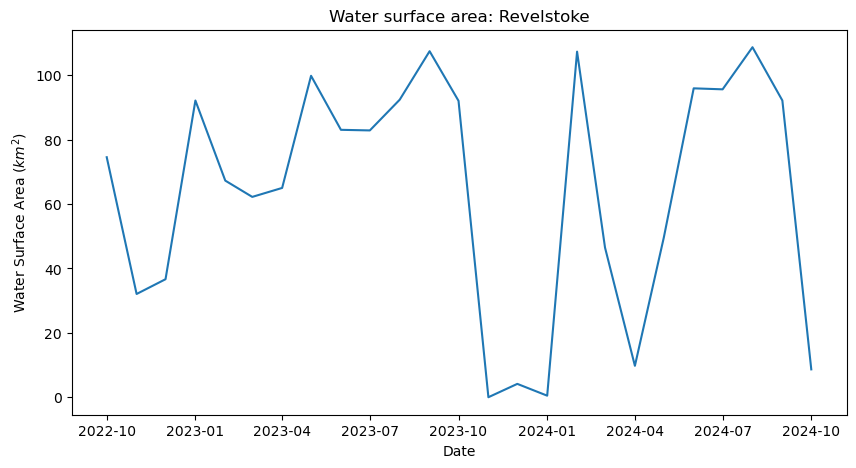

In [44]:
import pandas as pd

# convert temperature series to pandas dataframe
area_df = geemap.ee_to_df(area_series)
area_df["date"] = pd.to_datetime(area_df["date"])
area_df["water_area"] = area_df["water_area"] * 1e-6  # m2 to km2

f, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    area_df['date'], area_df['water_area'], label='Area'
)
ax.set_xlabel('Date')
ax.set_ylabel('Water Surface Area ($km^2$)')
ax.set_title(f'Water surface area: {DAM}')

## calculate storage and storage change <a class="anchor" id="calculate-storage"></a>

To calculate the storage, or the volume of water in the reservoir, we need the Area-Volume curve. The Area-Volume curve relates the inundadted surface area of the reservoir with its volume. The AV curves are provided to you for the dams in the `assets/aev` directory. Let's load and plot it.

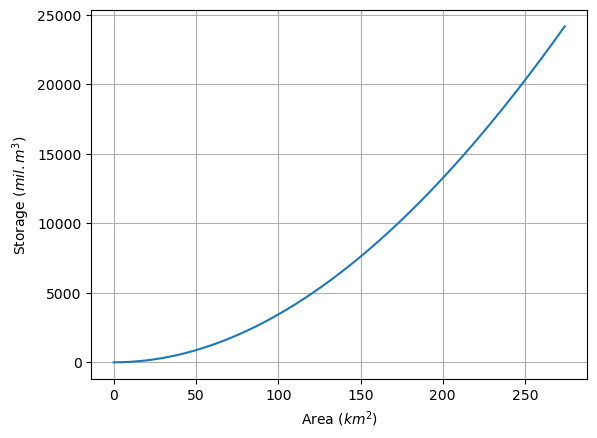

In [45]:
# read area-volume curve
aev = pd.read_csv(f"assets/aev/{DAM}.csv", comment='#')

f, ax = plt.subplots()
ax.plot(aev['CumArea'], aev['Storage (mil. m3)'])
ax.set_xlabel('Area ($km^2$)')
ax.set_ylabel('Storage ($mil. m^3$)')
ax.grid()

We will use this relationship to calculate the storage. We can use the [`np.interp`](https://numpy.org/doc/stable/reference/generated/numpy.interp.html) function from `numpy` to interpolate the storage for the observed area based on the known area-storage relation. It takes three arguments. First, the x-coordinates at which to evaluate the interpolated values. The next two arguments are the x- and y- coordinates of the data points that will be used for interpolation.

Once we have the storage, we can using the [`.diff()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.diff.html) function to calculate the storage change.

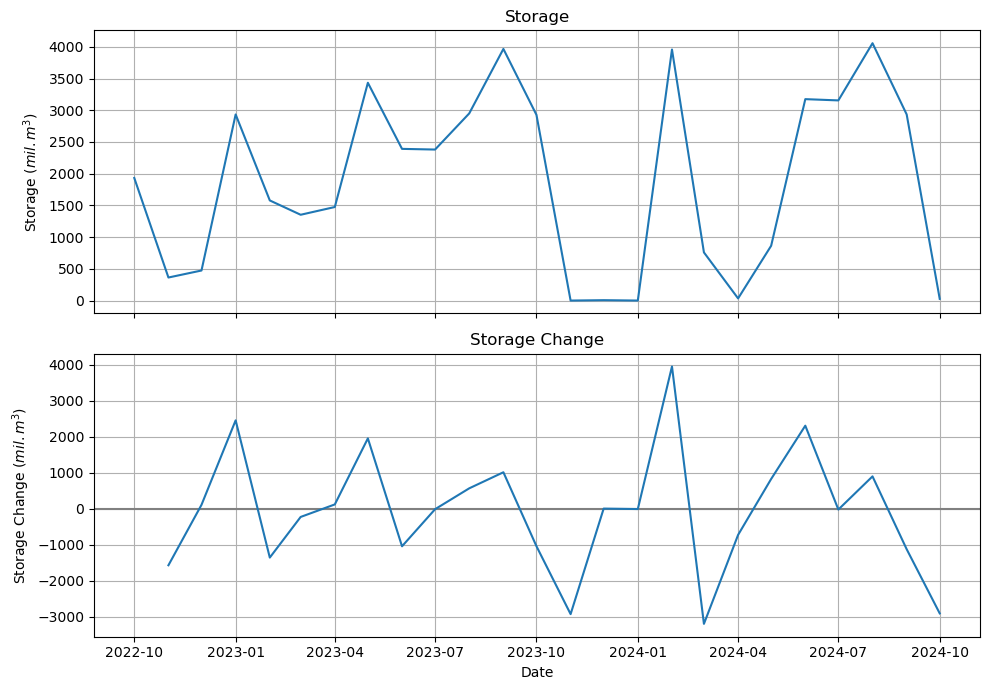

In [46]:
storage_df = area_df.copy()
storage_df['storage (mil. m3)'] = np.interp(
    area_df['water_area'],
    aev['CumArea'], aev['Storage (mil. m3)']
)
storage_df['storage_change (mil. m3)'] = storage_df['storage (mil. m3)'].diff()

f, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 7), sharex=True)
ax1.plot(
    storage_df['date'], storage_df['storage (mil. m3)'], label='Storage'
)
ax1.set_ylabel('Storage ($mil. m^3$)')
ax1.set_title(f'Storage')
ax1.grid()

ax2.axhline(0, color='gray') # highlight 0 storage change 
ax2.plot(storage_df['date'], storage_df['storage_change (mil. m3)'], label='Storage')
ax2.set_xlabel('Date')
ax2.set_ylabel('Storage Change ($mil. m^3$)')
ax2.set_title(f'Storage Change')
ax2.grid()

f.tight_layout()